# Importy

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Zadanie 1 - Strategie dla ryzyka związanego z ceną miedzi

# Pobranie i krótka analiza danych

In [15]:
try:
    data = yf.download('HG=F', period='6y')['Close']
    data.to_csv('copper_prices.csv')
    print('Dane pobrane z Yahoo Finance i zapisane do copper_prices.csv.')
except Exception as e:
    print(f'Błąd pobierania danych: {e}')
    data = pd.read_csv('copper_prices.csv', index_col=0, parse_dates=True)
    print('Dane wczytane z pliku copper_prices.csv.')


[*********************100%***********************]  1 of 1 completed

Dane pobrane z Yahoo Finance i zapisane do copper_prices.csv.


In [16]:
S0 = data.iloc[-1].item()
log_returns = np.ravel(np.log(data / data.shift(1)).dropna())
sigma = np.std(log_returns) * np.sqrt(252)
print(f'Aktualna cena miedzi: {S0:.2f} USD/lb')
print(f'Zmienność roczna: {sigma:.2%}')

Aktualna cena miedzi: 4.81 USD/lb
Zmienność roczna: 24.00%


# Obliczenie możliwych cen, cen dla opcji, zysków i strat oraz stworzenie tabeli

In [25]:
notional = 1000  # funty miedzi
T = 90 / 365  # 90 dni
r = 0.0425  # stopa wolna od ryzyka

# Kwantyle – możliwe przyszłe ceny
quantiles = np.linspace(0.05, 0.95, 20)
future_prices = S0 * np.exp(norm.ppf(quantiles) * sigma * np.sqrt(T) - 0.5 * sigma**2 * T)

# Premia opcyjna  (Black - Scholes)
def call_option_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

K = S0  # Strike = dzisiejsza cena
call_premium = call_option_price(S0, K, T, r, sigma)
premium_total = call_premium * notional
print(f'Premia opcyjna: {call_premium:.4f} USD/lb (łącznie: {premium_total:.2f} USD)')

# Tworzenie tabeli
rows = []
for price in future_prices:
    # Koszt bez zabezpieczenia: zakup po przyszłej cenie
    cost_unhedged = price * notional
    pnl_unhedged = (S0 - price) * notional

    # Koszt forward: cena z góry ustalona
    cost_forward = K * notional
    pnl_forward = (S0 - K) * notional  # stałe, niezależne od future_price

    # Koszt opcji kupna: kupujemy po K, jeśli cena > K; w przeciwnym razie po cenie rynkowej
    exercise = price > K
    purchase_price = K if exercise else price
    cost_option = purchase_price * notional + premium_total
    pnl_option = (S0 * notional - cost_option)

    rows.append([
        price,
        cost_unhedged, pnl_unhedged,
        cost_forward, pnl_forward,
        cost_option, pnl_option
    ])


df = pd.DataFrame(rows, columns=[
    'Przyszła cena miedzi (USD/lb)',
    'Koszt: Bez zabezp. (USD)', 'Zysk/Strata: Bez zabezp. (USD)',
    'Koszt: Forward (USD)', 'Zysk/Strata: Forward (USD)',
    'Koszt: Opcja kupna (USD)', 'Zysk/Strata: Opcja kupna (USD)'
])


def stylizuj_tabelę(df):
    def kolor_wartosci(val):  # Do kosztów
        if val < S0 * notional:
            return 'color: lightgreen'
        elif val > S0 * notional:
            return 'color: red'
        return 'color: white'

    style = [
        {'selector': 'th, td', 'props': [('border', '0.5px solid white')]},
        {'selector': 'td.col0, th.col0', 'props': [('border-right', '4px solid white')]},
        {'selector': 'td.col2, th.col2', 'props': [('border-right', '4px solid white')]},
        {'selector': 'td.col4, th.col4', 'props': [('border-right', '4px solid white')]},
        {'selector': 'th', 'props': [('font-weight', 'bold')]}
    ]

    return (
        df.style.format(precision=2)
        .set_table_styles(style)
        .map(kolor_wartosci, subset=['Koszt: Bez zabezp. (USD)',
                                     'Koszt: Forward (USD)',
                                     'Koszt: Opcja kupna (USD)'])
    )


styled_df = stylizuj_tabelę(df)
styled_df

Premia opcyjna: 0.2536 USD/lb (łącznie: 253.57 USD)


,Przyszła cena miedzi (USD/lb),Koszt: Bez zabezp. (USD),Zysk/Strata: Bez zabezp. (USD),Koszt: Forward (USD),Zysk/Strata: Forward (USD),Koszt: Opcja kupna (USD),Zysk/Strata: Opcja kupna (USD)
0,3.93,3929.38,885.12,4814.50,0.00,4182.95,631.55
1,4.10,4095.87,718.63,4814.50,0.00,4349.44,465.06
2,4.21,4213.42,601.08,4814.50,0.00,4467.00,347.50
3,4.31,4309.47,505.03,4814.50,0.00,4563.04,251.46
4,4.39,4393.58,420.92,4814.50,0.00,4647.15,167.35
5,4.47,4470.36,344.14,4814.50,0.00,4723.94,90.56
6,4.54,4542.51,271.99,4814.50,0.00,4796.08,18.42
7,4.61,4611.78,202.72,4814.50,0.00,4865.35,-50.85
8,4.68,4679.48,135.02,4814.50,0.00,4933.06,-118.56
9,4.75,4746.70,67.80,4814.50,0.00,5000.27,-185.77


# Wykresik

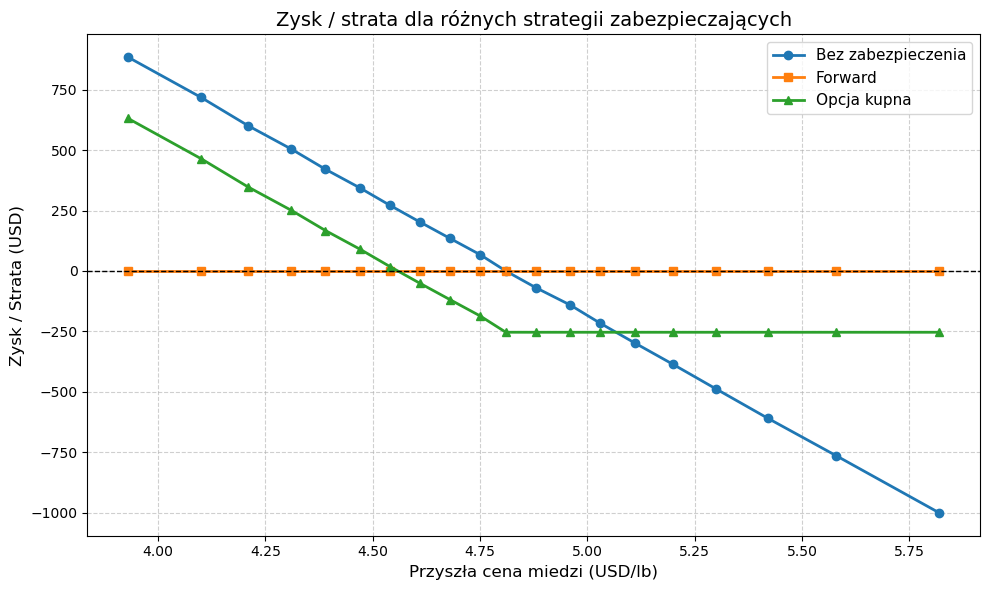

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Bez zabezp. (USD)'], label='Bez zabezpieczenia', marker='o', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Forward (USD)'], label='Forward', marker='s', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Opcja kupna (USD)'], label='Opcja kupna', marker='^', linewidth=2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Zysk / strata dla różnych strategii zabezpieczających', fontsize=14)
plt.xlabel('Przyszła cena miedzi (USD/lb)', fontsize=12)
plt.ylabel('Zysk / Strata (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# VaR

In [19]:
var_95_1 = round(np.quantile(df['Zysk/Strata: Bez zabezp. (USD)'], 0.05), 2)
var_95_2 = round(np.quantile(df['Zysk/Strata: Forward (USD)'], 0.05), 2)
var_95_3 = round(np.quantile(df['Zysk/Strata: Opcja kupna (USD)'], 0.05), 2)

print(f'VaR 95% – brak zabezpieczenia: {var_95_1} USD')
print(f'VaR 95% – zabezpieczenie forward: {var_95_2} USD')
print(f'VaR 95% – zabezpieczenie opcją: {var_95_3} USD')

print('---------------------')

var_99_1 = round(np.quantile(df['Zysk/Strata: Bez zabezp. (USD)'], 0.01), 2)
var_99_2 = round(np.quantile(df['Zysk/Strata: Forward (USD)'], 0.01), 2)
var_99_3 = round(np.quantile(df['Zysk/Strata: Opcja kupna (USD)'], 0.01), 2)

print(f'VaR 99% – brak zabezpieczenia: {var_99_1} USD')
print(f'VaR 99% – zabezpieczenie forward: {var_99_2} USD')
print(f'VaR 99% – zabezpieczenie opcją: {var_99_3} USD')


VaR 95% – brak zabezpieczenia: -776.71 USD
VaR 95% – zabezpieczenie forward: 0.0 USD
VaR 95% – zabezpieczenie opcją: -253.57 USD
---------------------
VaR 99% – brak zabezpieczenia: -956.37 USD
VaR 99% – zabezpieczenie forward: 0.0 USD
VaR 99% – zabezpieczenie opcją: -253.57 USD


# Inne miary wrażliwości dla strategii z opcją kupna

In [20]:
from scipy.stats import norm
import numpy as np

def option_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # na 1% zmienności
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    theta /= 365  # dzienna theta
    rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100  # na 1% zmiany stopy

    return delta, gamma, vega, theta, rho

# Parametry (przykład)
S = S0  # cena miedzi
K = S0  # strike = cena obecna
T = 30 / 365
r = 0.05
sigma = sigma

delta, gamma, vega, theta, rho = option_greeks(S, K, T, r, sigma)

print(f'Delta: {delta:.4f}')
print(f'Gamma: {gamma:.6f}')
print(f'Vega: {vega:.4f}')
print(f'Theta (dzienna): {theta:.4f}')
print(f'Rho: {rho:.4f}')


Delta: 0.5375
Gamma: 1.198841
Vega: 0.0055
Theta (dzienna): -0.0025
Rho: 0.0020


* **Delta** – wrażliwość ceny opcji na zmianę ceny instrumentu bazowego,
* **Gamma** – wrażliwość delty na zmianę ceny instrumentu bazowego,
* **Vega** – wrażliwość ceny opcji na zmianę zmienności (sigma),
* **Theta** – wrażliwość ceny opcji na upływ czasu,
* **Rho** – wrażliwość ceny opcji na zmianę stopy procentowej.

**Wyjaśnienie:**

* *Delta* bliska 0–1, mówi jak bardzo zmieni się cena opcji jeśli cena miedzi zmieni się o 1 USD.
* *Gamma* informuje, jak szybko zmienia się delta przy zmianie ceny instrumentu.
* *Vega* pokazuje, jak cena opcji zmienia się przy wzroście zmienności o 1 punkt procentowy.
* *Theta* mówi, ile opcji „traci” na wartości każdego dnia (koszt upływu czasu).
* *Rho* pokazuje wrażliwość opcji na zmianę stóp procentowych.



___
# <font color='deepskyblue'>Zadanie 2: Szacowanie Prawdopodobieństwa Niewypłacalności w Modelu KMV</font>

W tej części projektu ocenimy ryzyko kredytowe dwóch kluczowych dostawców Nvidii: **TSMC** oraz **Samsung Electronics**.  
Wykorzystamy do tego celu **model KMV**, który jest praktycznym zastosowaniem modelu Mertona do oceny prawdopodobieństwa niewypłacalności (*Probability of Default*, $PD$).


# <font color='lightgreen'>Wprowadzenie Teoretyczne - Model Mertona</font>

Model Mertona traktuje kapitał własny firmy (*Equity*) jako opcję kupna (*call option*) na aktywa tej firmy (*Assets*). Dług firmy (*Debt*) pełni rolę ceny wykonania (*strike price*) tej opcji.

Jeśli wartość aktywów $V$ w momencie zapadalności długu $T$ jest wyższa niż wartość długu $D$, właściciele "wykonują opcję" – spłacają dług i zatrzymują pozostałą wartość aktywów $V - D$.  
Jeśli wartość aktywów jest niższa niż dług, właściciele pozwalają opcji wygasnąć – ogłaszają bankructwo, a wierzyciele przejmują aktywa firmy.  
Niewypłacalność następuje, gdy $V_T < D$.

## Kluczowe równania modelu

Do wyznaczenia wartości aktywów $V$ i ich zmienności $\sigma_A$, które nie są bezpośrednio obserwowalne, rozwiązujemy układ dwóch nieliniowych równań:

$$
\begin{cases}
E = V \cdot N(d_1) - D \cdot e^{-rT} \cdot N(d_2) \\
\sigma_E \cdot E = \sigma_A \cdot V \cdot N(d_1)
\end{cases}
$$

gdzie:

$$
d_1 = \frac{\ln(V/D) + (r + 0.5 \cdot \sigma_A^2) \cdot T}{\sigma_A \sqrt{T}}, \quad
d_2 = d_1 - \sigma_A \sqrt{T}
$$

### Zmienne:

- $E$ – Kapitalizacja rynkowa (wartość kapitału własnego)  
- $\sigma_E$ – Zmienność kapitału własnego (obserwowana na rynku akcji)  
- $D$ – Próg niewypłacalności (wartość długu)  
- $r$ – Stopa wolna od ryzyka  
- $T$ – Horyzont czasowy (zwykle 1 rok)  
- $V$ – Wartość aktywów firmy (niewiadoma)  
- $\sigma_A$ – Zmienność aktywów firmy (niewiadoma)  
- $N(\cdot)$ – Dystrybuanta standardowego rozkładu normalnego


# <font color='lightgreen'> Przygotowanie Danych Wejściowych</font>

Na podstawie danych rynkowych i finansowych z pierwszego kwartału 2025 roku, zbieramy następujące informacje:

| **Wielkość (stan na 31 III 2025)**                  | **Źródło**               | **TSMC**                      | **Samsung Electronics**            |
|------------------------------------------------------|---------------------------|--------------------------------|------------------------------------|
| Kapitalizacja rynkowa ($E$)                          | notowania giełdowe        | 880 mld USD                   | 384 mld USD                        |
| Zobowiązania ogółem                                  | raporty finansowe         | 2 143 736 mln NTD (≈ 66 mld USD) | 112 340 mld KRW (≈ 82 mld USD)    |
| Stopa wolna od ryzyka ($r$)                          | rentowność US 1Y Treasury | 4.25%                          | 4.25%                              |
| Horyzont czasowy ($T$)                               | założenie modelu          | 1 rok                          | 1 rok                              |

---

### Próg niewypłacalności (Default Point, $D$):

Model KMV często definiuje próg niewypłacalności jako sumę zobowiązań krótkoterminowych i połowę zobowiązań długoterminowych.  
Z powodu braku szczegółowego rozbicia w dostępnych raportach, stosujemy konserwatywne uproszczenie:

$$
D \approx 0.5 \times \text{Zobowiązania ogółem}
$$


In [21]:
# Import niezbędnych bibliotek
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from mpmath import findroot  # Solver do układów równań nieliniowych
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import fsolve # Używamy solwera z biblioteki SciPy
import warnings

# Ustawienia wizualne
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Krok 1: Definicja danych wejściowych
# ------------------------------------

# Dane dla TSMC
E_tsmc = 880e9  # 880 mld USD
L_tsmc = 66e9   # 66 mld USD (Total Liabilities)
D_tsmc = 0.5 * L_tsmc # Próg niewypłacalności

# Dane dla Samsung Electronics
E_samsung = 384e9  # 384 mld USD
L_samsung = 82e9   # 82 mld USD (Total Liabilities)
D_samsung = 0.5 * L_samsung # Próg niewypłacalności

# Parametry wspólne
r = 0.0425  # 4.25% stopa wolna od ryzyka
T = 1.0     # Horyzont 1 roku

print("--- DANE WEJŚCIOWE DO MODELU ---")
print(f"TSMC:")
print(f"  Kapitalizacja (E): {E_tsmc/1e9:.2f} mld USD")
print(f"  Próg niewypłacalności (D): {D_tsmc/1e9:.2f} mld USD")
print(f"\nSamsung Electronics:")
print(f"  Kapitalizacja (E): {E_samsung/1e9:.2f} mld USD")
print(f"  Próg niewypłacalności (D): {D_samsung/1e9:.2f} mld USD")

--- DANE WEJŚCIOWE DO MODELU ---
TSMC:
  Kapitalizacja (E): 880.00 mld USD
  Próg niewypłacalności (D): 33.00 mld USD

Samsung Electronics:
  Kapitalizacja (E): 384.00 mld USD
  Próg niewypłacalności (D): 41.00 mld USD


Zmienność kapitału własnego ($\sigma_E$) szacujemy jako **roczne odchylenie standardowe logarytmicznych stóp zwrotu z akcji** danej spółki,  
na podstawie danych historycznych (np. z ostatnich 3 lat).


In [22]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# --- Funkcje Pomocnicze ---

def equity_sigma(ticker: str, years: int = 3) -> float:
    """Oblicza roczną zmienność log-zwrotów dla danego tickera."""
    df = yf.download(ticker, period=f'{years}y', auto_adjust=True, progress=False)
    px = df['Close'].dropna()
    log_returns = np.log(px / px.shift(1)).dropna()
    sigma = log_returns.std() * np.sqrt(252)
    return sigma.item()  # Zwraca czystą liczbę (float)

def solve_merton(E, sigma_E, D, r=0.0425, T=1.0):
    """Rozwiązuje układ równań Mertona, aby znaleźć V i sigma_A."""
    def equations(vars):
        V, sigma_A = vars
        # Zabezpieczenie przed wartościami niedozwolonymi dla logarytmu i pierwiastka
        if V <= 0 or sigma_A <= 0:
            return (1e9, 1e9)
            
        d1 = (np.log(V / D) + (r + 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
        d2 = d1 - sigma_A * np.sqrt(T)
        
        eq1 = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2) - E
        eq2 = sigma_A * V * norm.cdf(d1) - sigma_E * E
        return (eq1, eq2)

    # Początkowe przybliżenia dla solwera
    V0, s0 = E + D, sigma_E
    
    # Użycie fsolve do znalezienia rozwiązania
    V, sigma_A = fsolve(equations, (V0, s0), xtol=1e-10)
    return V, sigma_A

def distance_to_default(V, sigma_A, D, r=0.0425, T=1.0):
    """Oblicza Distance-to-Default (DD) i Probability of Default (PD)."""
    DD = (np.log(V / D) + (r - 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
    PD = norm.cdf(-DD)
    return DD, PD

Mając zdefiniowane funkcje, przygotowujemy słownik z danymi wejściowymi dla TSMC i Samsunga, a następnie w pętli wykonujemy wszystkie niezbędne obliczenia, zapisując wyniki z powrotem w słowniku.

In [23]:
# --- Dane Wejściowe ---
data_dict = {
    'TSMC':    {'E': 880e9, 'Liab': 66e9, 'ticker': 'TSM'},
    'Samsung': {'E': 384e9, 'Liab': 82e9, 'ticker': '005930.KS'}
}
r, T = 0.0425, 1.0 # Stopa wolna od ryzyka i horyzont czasowy

# --- Główna Pętla Obliczeniowa ---
print("Uruchamiam obliczenia dla obu firm...")

for firm, info in data_dict.items():
    print(f"  Przetwarzam: {firm}...")
    # Krok 1: Oblicz próg niewypłacalności
    info['D'] = 0.5 * info['Liab']
    
    # Krok 2: Oblicz zmienność kapitału własnego
    info['sigma_E'] = equity_sigma(info['ticker'])
    
    # Krok 3: Rozwiąż równania Mertona dla V i sigma_A
    info['V'], info['sigma_A'] = solve_merton(
        info['E'], info['sigma_E'], info['D'], r, T
    )
    
    # Krok 4: Oblicz DD i PD
    info['DD'], info['PD'] = distance_to_default(
        info['V'], info['sigma_A'], info['D'], r, T
    )

print("\n✓ Obliczenia zakończone pomyślnie.")

Uruchamiam obliczenia dla obu firm...
  Przetwarzam: TSMC...
  Przetwarzam: Samsung...

✓ Obliczenia zakończone pomyślnie.


Wyniki modelu dla obu firm przedstawiamy w zbiorczej tabeli oraz na wykresie słupkowym porównującym ich roczne prawdopodobieństwo niewypłacalności (PD).

,E_mld,Liab_mld,D_mld,sigma_E,sigma_A,DD,PD
TSMC,880,66,33,38.82%,37.47%,8.78,0.0000%
Samsung,384,82,41,27.24%,24.71%,9.50,0.0000%


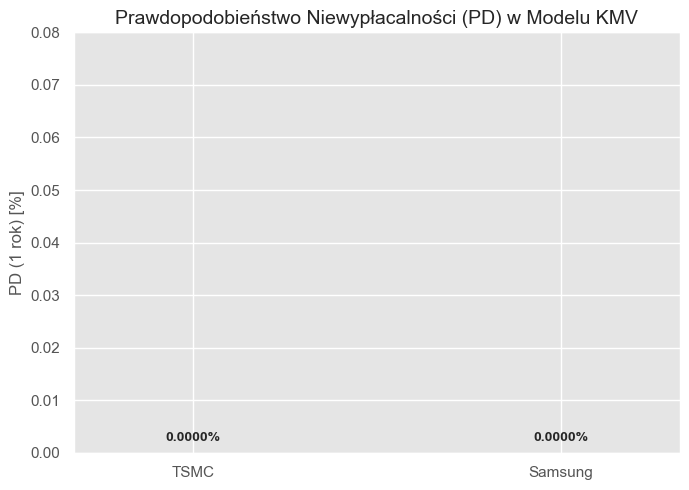

In [24]:
# --- Prezentacja Wyników w Tabeli ---
# Konwersja słownika wyników na elegancką tabelę w Pandas
out_df = (pd.DataFrame(data_dict).T
          .assign(E_mld=lambda d: d.E / 1e9,
                  Liab_mld=lambda d: d.Liab / 1e9,
                  D_mld=lambda d: d.D / 1e9)
          .loc[:, ['E_mld', 'Liab_mld', 'D_mld', 'sigma_E', 'sigma_A', 'DD', 'PD']])

# Wyświetlenie sformatowanej tabeli
display(out_df.style.format({
    'E_mld': '{:.0f}', 'Liab_mld': '{:.0f}', 'D_mld': '{:.0f}',
    'sigma_E': '{:.2%}', 'sigma_A': '{:.2%}',
    'DD': '{:.2f}', 'PD': '{:.4%}'
}).set_caption("Tabela – wyniki modelu KMV (T = 1 rok)"))


# --- Wizualizacja Porównawcza PD ---
# Przygotowanie danych do wykresu
pd_values_percent = out_df['PD'].astype(float).values * 100
company_names = out_df.index

# Zabezpieczenie na wypadek bardzo małych wartości PD dla estetyki wykresu
safe_top_limit = max(pd_values_percent.max() * 1.4, 0.08)

# Tworzenie wykresu
plt.figure(figsize=(7, 5))
bars = plt.bar(company_names, pd_values_percent, color=['skyblue', 'steelblue'], width=0.5)

# Dodawanie etykiet nad słupkami
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + safe_top_limit * 0.02,
             f"{height:.4f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Prawdopodobieństwo Niewypłacalności (PD) w Modelu KMV', fontsize=14)
plt.ylabel('PD (1 rok) [%]', fontsize=12)
plt.ylim(0, safe_top_limit)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

### Wnioski z modelu KMV (T = 1 rok)

* Dla obu kontrahentów PD(1 Y) ≈ 0 % – wartości praktycznie zerowe.
* Powód: **E ≫ D oraz krótki horyzont** ⇒ bardzo wysoki Distance-to-Default  
  (TSMC ≈ 8,8; Samsung ≈ 9,5).
* Wniosek operacyjny dla Nvidii: **ryzyko kredytowe dostawców jest zaniedbywalne** w skali jednego roku, więc nie wymaga natychmiastowego credit enhancement.
* Uwaga metodologiczna: przy dłuższym horyzoncie (T > 1 rok) lub wyższym progu defaultu (np. ST + ½ LT) PD rośnie do wartości < 1 %, ale wciąż pozostaje niskie.
